<img src="images/header.png" alt="Header" style="width: 400px;"/>

<h1 align="center">Predictive Maintenance using NVIDIA RAPIDS and Deep Learning Models</h1>
<h4 align="center">Part 1: Training GPU XGBoost models with RAPIDS for Time Series</h4>



Working with time series algorithms can be difficult to configure and apply to arbitrary sequence prediction problems, even with well-defined and “easy to use” interfaces like those provided in the tf.keras deep learning library in Python.  One reason for this difficulty is the need for Deep Learning layers to input and return sequences rather than single values.

In this course, we will take a publicly available time series dataset of hard drive operational metrics provided by <a href="https://www.backblaze.com/b2/hard-drive-test-data.html">Backblaze</a>, to build out and compare machine learning vs deep learning approaches to predictive maintenance problems. 

The course materials are categorized in three sections. In this lab, we take a machine learning approach called “XGBoost” for classification of faulty/normal hard drives and discuss performance optimizations by utilizing accelerated computing. In lab 2, we move on to deep learning models and start with recurrent networks to predict the time series. We further explore variations of recurrent networks such as CNN-LSTM models. Lab 3, addresses applications of autoencoders to classify hard drives into faulty and normal bins. Throughout these labs, you will have the opportunity to get familiarized with details of implementations for each model, and learn how to curate the data and evaluate results. To begin, we start with "Training GPU XGBoost models with RAPIDS for Time Series". This lab covers the following topics:

* [Background](#1)
* [Predictive Maintenance: Predicting Anomalies Accurately and Early](#2)
* [Lab Overview](#3)
* [Dataset Loading and Pre-Processing](#4)
* [Training GPU XGBoost models with RAPIDS for Time Series](#5)
* [XGBoost](#6)
* [More on Data Preparation](#7)
    * [Exercise 1: Remove "zero-valued" columns](#e1)
* [Define XGBoost Model Parameters](#8)
* [Train XGBoost on CPUs](#9)
* [Training with GPU without cuDF DataFrame](#10)
* [Training with GPU and cuDF](#11)
* [XGBoost Model Accuracy](#12)
* [Measuring Model Accuracy](#13)
* [Interpreting the results](#14)
* [Dealing with Imbalanced Data](#15)
    * [Exercise 2: Implications of balancing data samples](#e2)


<a name="1"></a>
## Background

One of the important recent topics of interest for industrial organizations  is to move away from reactive and schedule-based maintenance to <b>predictive maintenance</b> that helps optimize the operations and improve productivity.

<a name="2"></a>
### Predictive Maintenance: Predicting Anomalies Accurately and Early

Whereas schedule-based maintenance provides a regularly scheduled time for part replacements and repairs, predictive maintenance represents a condition based approach driven by data and analytics. Predictive maintenance strives to identify anomalies that can lead to costly breakdowns, such as improper machinery lubrication, contamination, misalignment, or suboptimal humidity and temperature conditions.

By identifying such anomalies of many part failures, estimating remaining useful life of these parts and then mapping anomalies to failure conditions by interpreting service logs, predictive maintenance helps to manage failures and avoid costly unplanned downtime. Other benefits include fewer unnecessary repairs, optimized spare parts inventory, and longer lifespans of equipment and parts—ultimately increasing equipment availability while improving operational efficiency. 

In this regard, our goal in this lab is to show you how you can take your company's time series data and leverage it to predict outcomes.

<a name="3"></a>
## Lab Overview

One of the common problems in a datacenter is failing data storage disks. Current business applications transfer large amounts of data and put very big pressure on the disks.  Using hard drive S.M.A.R.T. (Self-Monitoring Analysis and Reporting Technology) data provided from Backblaze, we will build conventional Machine Learning models in addition to Deep Learning methods to predict RUL (Remaining Useful Life) of a hard drive.

- Dataset - https://www.backblaze.com/b2/hard-drive-test-data.html
- Research paper from IBM - https://researcher.watson.ibm.com/researcher/files/us-mqiao/BigDataCongress_2018.pdf

After completing this Lab, you will know how to take time series data and:

- Predict Failure using a machine learning classification model with XGBoost
- Predict Failure using a deep learning classification model using LSTM
- Detect Anomalies using an Autoencoder (AE) or Seq2Seq model


Let's start by importing some libraries used throughout this lab.

In [1]:
# Import libraries that will be needed for the Lab
import pandas as pd
import numpy as np

import sys
import glob
import os

import datetime
import time
import gc
import math
import random
from random import shuffle, randrange

from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import *

import matplotlib.pyplot as plt

<a name="4"></a>
## Dataset Loading and Pre-Processing

The data set consists of a daily snapshot of each operational hard drive in the Backblaze datacenter at the time of measurement.  Each snapshot includes basic drive information along with S.M.A.R.T. statistics reported by that drive.


In [2]:
# Define location of our input and prepared data files
data_dir = './data/'

csv_train_file = 'Lab1-2017-Full_data.csv.gz'
csv_test_file = 'Lab1-2016-Q4_data.csv.gz'

pkl_train_file = 'Lab1-2017-Full-ST4000DM000.pkl'
pkl_test_file = 'Lab1-2016-Q4-ST4000DM000.pkl'

In [3]:
# Read entire SMART training data set
# - Full 2017 dataset takes about 4 minutes to read in

print('Reading training data set...')
df = pd.read_csv(data_dir + csv_train_file)
print('Finished reading training data set')

df.head()

Reading training data set...
Finished reading training data set


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2017-02-01,MJ0351YNG9Z0XA,Hitachi HDS5C3030ALA630,3000592982016,0,100.0,0.0,135.0,108.0,127.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-02-01,MJ0351YNG9WJSA,Hitachi HDS5C3030ALA630,3000592982016,0,100.0,0.0,136.0,104.0,126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-02-01,PL1321LAG34XWH,Hitachi HDS5C4040ALE630,4000787030016,0,100.0,0.0,134.0,101.0,130.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-02-01,MJ0351YNGABYAA,Hitachi HDS5C3030ALA630,3000592982016,0,100.0,0.0,136.0,104.0,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-02-01,Z305B2QN,ST4000DM000,4000787030016,0,117.0,124084032.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print(df.shape)

(30471787, 95)


## Data Set Overview<br>

The dataset in this DLI course is provided by Backblaze. More documentation can be found [here](https://www.backblaze.com/b2/hard-drive-test-data.html) about the type of the data and the different sensors which indicate the health of the hard drives. Following is a list of key parameters reported in the dataset. 

- <b>Date:</b> The date of the entrie recording in yyyy-mm-dd format.

- <b>Serial Number:</b> The manufacturer-assigned serial number of the drive.

- <b>Model:</b> The manufacturer-assigned model number of the drive.

- <b>Capacity:</b> The drive capacity in bytes.

- <b>Failure:</b> Contains a “0” if the drive is OK. Contains a “1” if this is the last day the drive was operational before failing.

- <b>SMART Stats:</b> – 90 columns of data, which are the Raw and Normalized values for 45 different SMART stats as reported by the given drive. Each value is the number reported by the drive.


From the snapshot above, one important thing to notice is that we have several different models for which data is recorded. First, let's take a look at number of samples for each model:

In [5]:
# let's review the available hard drive models and select one with lot of samples for this exercise
print(df.model.value_counts())

ST4000DM000             12237899
HGST HMS5C4040BLE640     5154696
ST8000DM002              3523493
HGST HMS5C4040ALE640     2728104
ST8000NM0055             2664020
                          ...   
TOSHIBA HDWE160               64
WDC WD10EADX                  59
WDC WD10EARS                  32
 00MD00                       14
WDC WD1000FYPS                11
Name: model, Length: 68, dtype: int64


Because SMART stats usage can vary in meaning from manufacturer to manufacturer, we will limit our training data to a specific hard drive model, to reduce  potential of other manufactures' usage from influencing our model. We will pick the `ST4000DM000` model, which has the largest number of samples.

In [6]:
# ST4000DM000 is the most popular drive so let's use this to train
harddrive_model = 'ST4000DM000'

# keep only the selected hard drive model we want in our training data set
df = df[df.model == harddrive_model]

# Load test set from Q2 data and pre-selected model
print('Reading test data set...')
df_t = pd.read_csv(data_dir + csv_test_file)
print('Finished reading test data set')

# keep only the selected hard drive model we want in our test data set
df_t = df_t[df_t.model == harddrive_model]

Reading test data set...
Finished reading test data set


In [7]:
#converting string to date time format for sorting and plotting time series data 

df['date'] = pd.to_datetime(df['date'])
df_t['date'] = pd.to_datetime(df_t['date'])

In [8]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plot_df(df,loc_col_list,axs):   
    df_normal = df[df['failure']==0]
    df_failed = df[df['failure']==1]
    
    n_rows = len(loc_col_list)
    cmap = get_cmap(n_rows) 
    color_list = random.sample(range(n_rows),n_rows)
    
    for i, cur_col in enumerate(loc_col_list):
        cur_min = df[cur_col].min() 
        cur_max = df[cur_col].max()
        
        axs[i].plot(df_normal['date'], df_normal[cur_col],'.', color=cmap(color_list[i]), markersize=5,alpha=0.2)
        axs[i].plot(df_failed['date'], df_failed[cur_col],'.', color=cmap(color_list[i]), markersize=20,alpha=0.6)
        axs[i].set_ylabel(cur_col)

In [9]:
def remove_constant_values(df,check_str): 
    col_list = df.columns.tolist()
    loc_col_list = [] 
    
    print("Range for    : {:>25s} {:>15s}".format("min","max"))
    
    for cur_col in col_list:
        if check_str in cur_col:
            cur_min = df[cur_col].min() 
            cur_max = df[cur_col].max()

            if cur_min != cur_max : 
                print("  {:20s}   {:15d} {:15d} ".format(cur_col,int(cur_min),int(cur_max)))
                loc_col_list.append(cur_col)
                
    print("")
    return loc_col_list 

### Cleaning and understanding input data 
While building any machine learning/deep learning model, it is important to understand the quality and structure of the input data. For example, there can be missing data for several days for some of the sensors. There can also be sensors which do not have any data. The input data needs to be curated to remove such sensors and adjust the data for the sensors with missing values. 

In [10]:
# First, let's remove columns that have no valid data
df = df.dropna(axis='columns', how='all') 
# Next, let's remove a few rows that had invalid data (most likely error reading SMART statistics)
df = df.dropna(axis='rows', how='any')

df_failed = df[df['failure']==1]
df_normal = df[df['failure']==0]

col_list_raw = remove_constant_values(df_failed,"_raw")
col_list_normalized = remove_constant_values(df_failed,"_normalized")
col_list = ['date', 'serial_number', 'model', 'capacity_bytes', 'failure'] 
col_list = col_list + col_list_raw + col_list_normalized

df = df[col_list]

#keep the same columns as the training dataframe 
df_t = df_t[col_list]

#fill in the small number of null values in remaining columns 
df = df.fillna(0)
df_t = df_t.fillna(0)

Range for    :                       min             max
  smart_1_raw                      20608       243737992 
  smart_4_raw                          1             297 
  smart_5_raw                          0           43248 
  smart_7_raw                          7 218859378419151 
  smart_9_raw                          0           39525 
  smart_12_raw                         0              76 
  smart_183_raw                        0             684 
  smart_184_raw                        0              62 
  smart_187_raw                        0             690 
  smart_188_raw                        0               7 
  smart_189_raw                        0             264 
  smart_190_raw                       14              42 
  smart_192_raw                        0             285 
  smart_193_raw                        5          574352 
  smart_194_raw                       14              42 
  smart_197_raw                        0           21608 
  smart_198_raw

In [11]:
# collecting the number of failed hard disks to compare the distributions of the sensor data with normal disks and also to plot time series data 

serial_num_list_failed = df_failed.serial_number.value_counts().index.tolist()

### Histogram of sensor data 
Once the data is curated, a typical histogram plot of the data can reveal key operating points, outliers and provide further suggestions for preparing the data. The raw SMART sensor data is plotted below. 

21

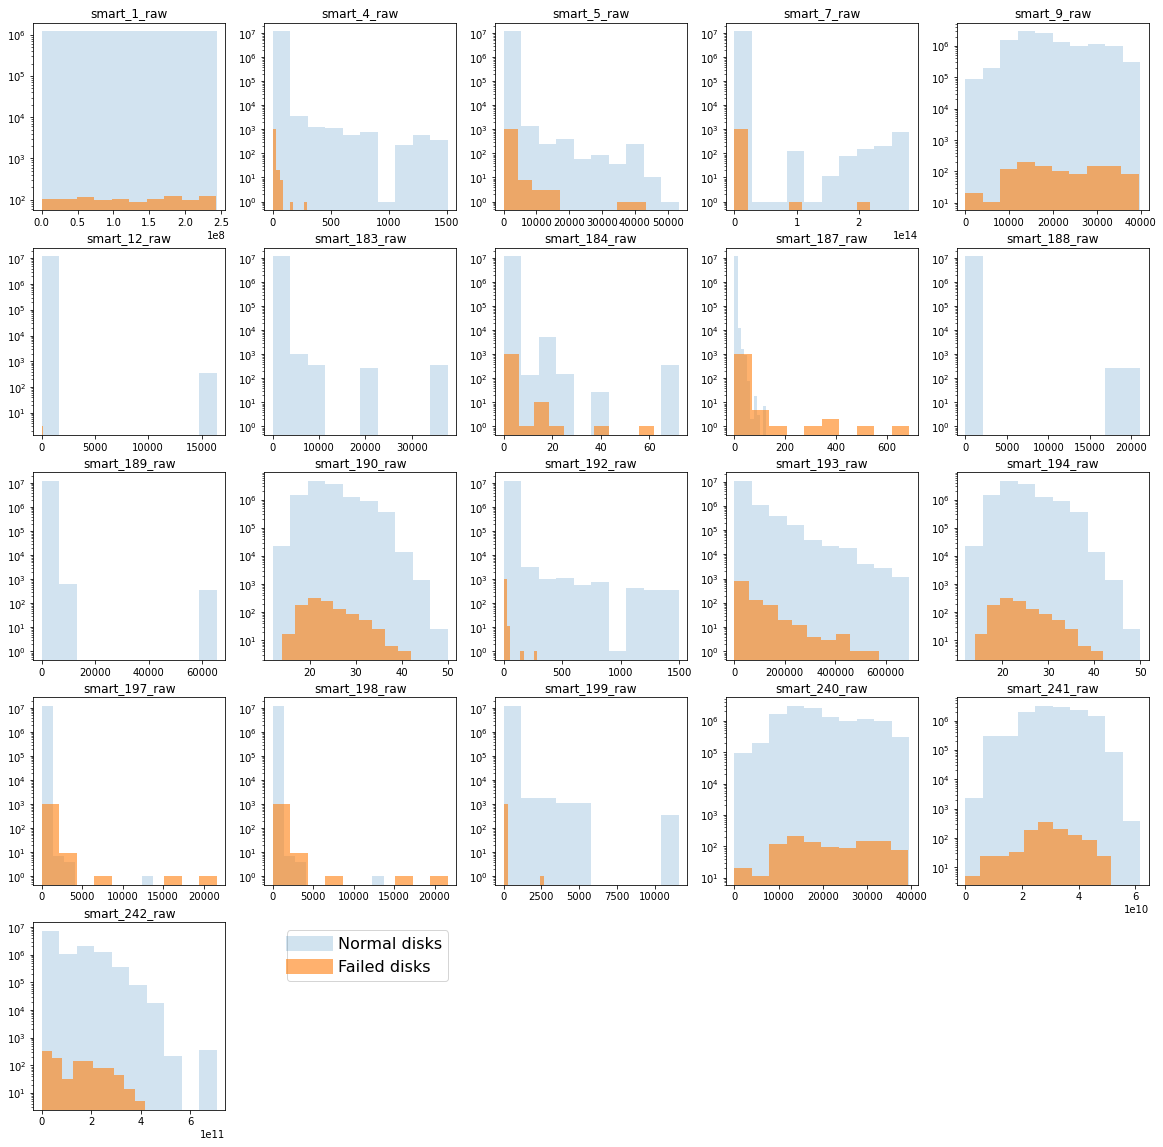

In [12]:
n = 5 
m = len(col_list_raw)//n 
if len(col_list_raw)%n > 0 : m += 1 
    
fig, axs = plt.subplots(figsize=(20,20), ncols=n, nrows=m)
axs = axs.flatten()

for i,cur_col in enumerate(col_list_raw): 
    axs[i].hist(df_normal[cur_col],alpha=0.2,color="tab:blue")
    axs[i].hist(df_failed[cur_col],alpha=0.6,color="tab:orange")
    axs[i].set_yscale('log')
    axs[i].set_title(cur_col)

for i in range(len(col_list_raw),axs.shape[0]): 
    axs[i].axis('off')

i = len(col_list_raw)
axs[i].plot([],[],alpha=0.2,color="tab:blue",label="Normal disks",linewidth=15)
axs[i].plot([],[],alpha=0.6,color="tab:orange",label="Failed disks",linewidth=15)
axs[i].legend(fontsize=16)
    
len(col_list_raw)

### Time series visualization 

Of all the disks with available data, several disks fail. Since the SMART sensor data is time series, it is useful to visualize the sensor behavior for the failed disks. In the plots below, the raw sensor data are displayed for 10 failed disks out of the 1061 failed disks. This can give us insights to the behavior of the disk until the time of failure. 

NOTE : 
    The large circles represent time of failure.
    The lines show the data leading up to the point of faiilure. 
    Only serial numbers of failed disks are being used.



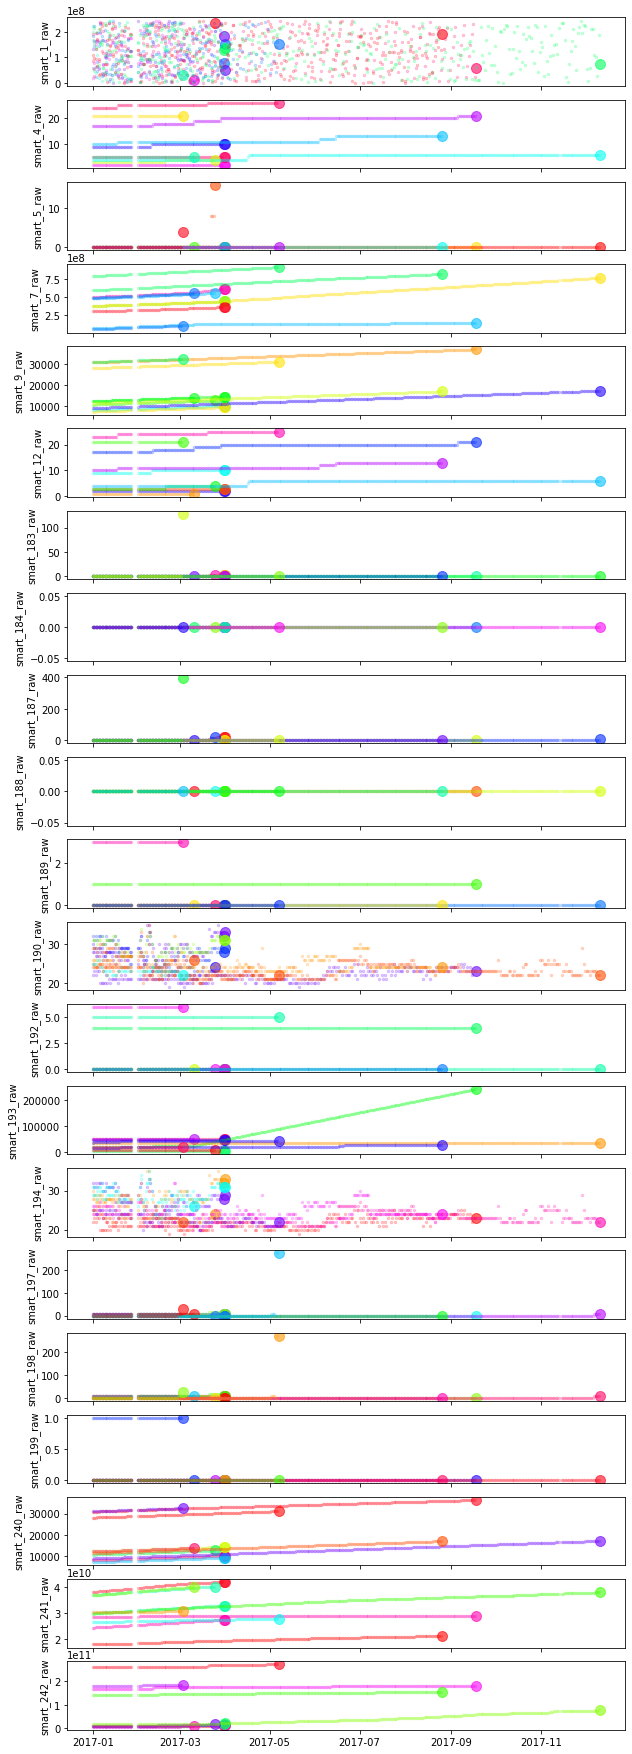

In [13]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


n_rows = len(col_list_raw)
fig, axs = plt.subplots(ncols=1, nrows=n_rows, 
                            figsize=(10,1.5*n_rows),sharex=True)
for cur_num in serial_num_list_failed[:10]: # [:1]: 
    plot_df(df[df['serial_number']==cur_num],col_list_raw,axs)

print("NOTE : \n    The large circles represent time of failure.\n    The lines show the data leading up to the point of faiilure. \n    Only serial numbers of failed disks are being used.\n")

In [14]:
# Save datasets for future use
print('Saving the train and test data sets...')
df.to_pickle(data_dir+pkl_train_file)
df_t.to_pickle(data_dir+pkl_test_file)
print('Completed saving data sets')

Saving the train and test data sets...
Completed saving data sets


<a name="5"></a>
## Training GPU XGBoost models with RAPIDS for Time Series

In this section, we will leverage the Backblaze Hard Drive SMART data to train an XGBoost model that will predict potential future failures.

XGBoost will use the historical collection of SMART data to learn common feature patterns present in disk failures.  The model we create will be able to predict a failure based on the characteristics learned. To implement our XGBoost model we will be using  NVIDIA's [RAPIDS](https://rapids.ai/) which is an open source, GPU accelerated, data science platform.  RAPIDS includes cuML which is a "scikit-learn-like" library that contains GPU-accelerated versions of some of the most popular machine learning algorithms.

In this lab, we will be using RAPIDS to train XGBoost models.

<a name="6"></a>
### XGBoost

XGBoost is widely known today as a "go to" model when working with structured data. In fact, there is a disproportionately large number of XGBoost-based winning entries of Kaggle competitions. In this lab, we introduce the model, but we do not intend to go through a rigorous mathematical formulation of XGBoost. For curious readers, we recommend reviewing of the original paper on [XGBoost](https://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf)

Traditionally, in tree-based ensemble methods such as Random Forests, we train each tree independently and the predictions of multiple trees are summed to obtain the final score. The figure below classifies whether someone would like to play computer games or not. The left and right trees are classifying gamers based on different features, namely age and whether samples use computers on a daily basis. A weighted combination of such trees would result in a more accurate decision.

<br>

<img src="img/twocart.png" style="margin-top:10px;"/>
<p style="text-align: center;color:gray"> Figure 1. Tree classifier to detect computer gamers<br/>
<i>Image credit: XGBoost: A Scalable Tree Boosting System, T. Chen and C. Guestrin</i></p>



In the case of XGBoost, an implementation of Gradient Boosted Decision Trees, we repeatedly build new models and combine them into an ensemble. Unlike Random Forests, we build trees one at a time, where each new tree helps to correct errors made by previously trained tree. The incremental training procedure is shown in figure 2.

<br/><br/>



<img src="img/Ensemble Tree.jpg" style="margin-top:10px;"/>
<p style="text-align: center;color:gray"> Figure 2. XGBoost training pipeline</p>





The loss function controls the predictive power of the model, and the XGBoost regularization term ensures simplicity and manages overfitting. Since "Boosting" focuses iteratively building learners for the most difficult parts of your data, it provides an efficient algorithm to deal with unbalanced datasets by strengthening the impact of the positive class. With this brief introduction to the method, we are going to further curate the data and implement the model.


<a name="7"></a>
## More on Data Preparation

Now that we have filtered the dataset based on the `model` column, this column is not required anymore and can be removed. Also, the `date` and `serial_number` do not possess any useful information for our training. Later in the course, where we treat the hard drive date as time sequences, we would need to further sort the data using the `date` column. Let's start by removing these unnecessary columns at this stage.

In [15]:
# RAPIDS
import cudf 
import xgboost as xgb

In [16]:
# drop unneccessary columns
print("Dropping unneeded columns...")
df = df.drop(columns=['model', 'date', 'serial_number'])
df_t = df_t.drop(columns=['model', 'date', 'serial_number'])

Dropping unneeded columns...


For training/testing our model, we require labels. The `failure` column provides these class labels. We need to extract these labels as follows:

In [17]:
print("Separating Training Data Features and Labels")
# separate training set features from labels
df_train_target = pd.DataFrame(df['failure'])

print("Separating Test Data Features and Labels")
# separate test set features from labels
df_test_target = pd.DataFrame(df_t['failure'])

print("Completed")

Separating Training Data Features and Labels
Separating Test Data Features and Labels
Completed


Each SMART measure on the list of columns has a companion "normalized" twin column. The values of the normalized column are just the scaled version of the "raw" columns. We can choose to opt either of these columns for this lab, as XGBoost is not sensitive to the scale of the values of each column. Here, we choose to keep the "raw" version.



In [18]:
cols = [c for c in df.columns if c.lower().find("normalized")==-1]
df=df[cols]
df.columns

Index(['capacity_bytes', 'failure', 'smart_1_raw', 'smart_4_raw',
       'smart_5_raw', 'smart_7_raw', 'smart_9_raw', 'smart_12_raw',
       'smart_183_raw', 'smart_184_raw', 'smart_187_raw', 'smart_188_raw',
       'smart_189_raw', 'smart_190_raw', 'smart_192_raw', 'smart_193_raw',
       'smart_194_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
       'smart_240_raw', 'smart_241_raw', 'smart_242_raw'],
      dtype='object')

<a name="e1"></a>
## Exercise 1: Remove "zero-valued" rows

Another important drawback with the data is "zero-valued" rows. These rows have zero values for every entry of the dataset and do not possess any useful information for training the model. We can remove these rows from the training sets.

In [19]:
#remove zero valued rows
# df = <<TO DO>>
df = df.loc[:, (df != 0).any(axis=0)]
df.columns

Index(['capacity_bytes', 'failure', 'smart_1_raw', 'smart_4_raw',
       'smart_5_raw', 'smart_7_raw', 'smart_9_raw', 'smart_12_raw',
       'smart_183_raw', 'smart_184_raw', 'smart_187_raw', 'smart_188_raw',
       'smart_189_raw', 'smart_190_raw', 'smart_192_raw', 'smart_193_raw',
       'smart_194_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
       'smart_240_raw', 'smart_241_raw', 'smart_242_raw'],
      dtype='object')

If you get stuck, click [here](#a1) for an answer.

Now that these columns are removed, we should apply the same to our test set. Note that for our test set, even if they contain non-zero values, since they are removed from the train set, they will not be useful. Also, we need to remove the `failure` column - which is our class labels! - from the training and testing sets.

In [20]:
cols = [c for c in df_t.columns if c.lower() in df.columns]
df_t=df_t[cols]

df_train = df.drop(columns=['failure'])
df_test = df_t.drop(columns=['failure'])
print("Completed")

Completed


Let's look at a few records from the dataset

In [21]:
df.head()

,capacity_bytes,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,smart_183_raw,smart_184_raw,...,smart_190_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
4,4000787030016,0,124084032.0,8.0,0.0,407077929.0,9938.0,8.0,0.0,0.0,...,24.0,0.0,33920.0,24.0,0.0,0.0,0.0,9690.0,3.179327e+10,8.596073e+09
7,4000787030016,0,22057080.0,21.0,0.0,789891767.0,17785.0,21.0,0.0,0.0,...,18.0,0.0,70545.0,18.0,0.0,0.0,0.0,17310.0,2.169678e+10,1.860347e+11
8,4000787030016,0,119535272.0,7.0,0.0,338259228.0,8600.0,7.0,0.0,0.0,...,29.0,0.0,9086.0,29.0,0.0,0.0,0.0,8514.0,2.755353e+10,1.631456e+10
12,4000787030016,0,90592144.0,12.0,0.0,64202331.0,18105.0,12.0,4466.0,0.0,...,21.0,0.0,14150.0,21.0,0.0,0.0,564.0,18051.0,2.150714e+10,2.376942e+11
13,4000787030016,0,240109536.0,20.0,0.0,664498121.0,14657.0,20.0,0.0,0.0,...,25.0,0.0,46665.0,25.0,0.0,0.0,0.0,14303.0,1.645696e+10,7.311286e+10


<a name="8"></a>
## Define XGBoost Model Parameters

Similar to other machine learning models, there are hyperparameters to be set for the XGBoost. Below is the list of parameters of the model:

- <b>max_tree_depth</b>:  Defines the maximum depth of the tree.  Deeper trees are more complex and able to learn more relations amongst the data, however, also tend to over-fit as the relations may be specific to the training set.

- <b>tree_method</b>:  Used to control GPU vs CPU operation.  'hist' = CPU histogram method.  'gpu_hist' = GPU histogram method.

- <b>subsample</b>:  Denotes the fraction of observations to be randomly sampled for each tree.  Lower values make the algorithm more conservative and prevent overfitting however, too small of a value might lead to underfitting.

- <b>regularization</b>:  Applies an L1-regularization term to the weights.  Increasing this value makes the model more conservative and can speed up performance on very high-dimensional data sets.

- <b>gamma</b>:  Gamma specifies the minimum loss reduction required to split a node.

- <b>pos_weight</b>:  Controls the balance of positive and negative weights to deal with unbalanced classes.

- <b>early_stop</b>:  Used to control over-fitting.  Attempts to find the inflection point when the performance on the test set starts to decrease while the performance on the training set continues to increase.

In [22]:
MAX_TREE_DEPTH = 8
TREE_METHOD = 'hist'
ITERATIONS = 85
SUBSAMPLE = 0.6
REGULARIZATION = 1.3
GAMMA = 0.3
POS_WEIGHT = 1
EARLY_STOP = 10

<a name="9"></a>
## Train XGBoost on CPUs

To demonstrate the benefits of GPU computing and the RAPIDS platform, we will first train a XGBoost model on the CPUs in our training enviroment. Let's take a look at the specs of the CPUs running on your cloud instance.

In [23]:
# Show information on the CPUs
!lscpu | grep 'Model name:'
!lscpu | grep 'CPU(s)'

Model name:            Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz
CPU(s):                48
On-line CPU(s) list:   0-47
NUMA node0 CPU(s):     0-47


First, we need to convert our data into XGBoost DMatrix format. DMatrix is optimized for memory efficiency and training speed in XGBoost. Next, we need to create a dictionary of hyperparameters discussed above and finally call the `train` method to start the training process. We also measure the total time to compare it with the GPU version.

In [24]:
start_time = time.time()

print('Converting data sets into XGBoost DMatrix format...')
xgtrain = xgb.DMatrix(df_train, df_train_target)
xgeval = xgb.DMatrix(df_test, df_test_target)
print('Completed converting data sets')

params = {'tree_method': TREE_METHOD, 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION,
          'gamma': GAMMA, 'subsample': SUBSAMPLE, 'scale_pos_weight': POS_WEIGHT, 'learning_rate': 0.05, 'silent': 1}

print('Starting CPU XGBoost Training...')
bst = xgb.train(params, xgtrain, ITERATIONS, evals=[(xgtrain, "train"), (xgeval, "eval")],
                early_stopping_rounds=EARLY_STOP)

timetaken_cpu = time.time() - start_time
print('CPU XGBoost training compeleted - elapsed time:', timetaken_cpu,'seconds')

# free up memory
del xgtrain
del xgeval
del bst

Converting data sets into XGBoost DMatrix format...
Completed converting data sets
Starting CPU XGBoost Training...
[05:28:12] WARNING: /conda/conda-bld/xgboost_1591204597597/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:0.47570	eval-rmse:0.47497
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:0.45096	eval-rmse:0.45146
[2]	train-rmse:0.42852	eval-rmse:0.42858
[3]	train-rmse:0.40691	eval-rmse:0.40738
[4]	train-rmse:0.38703	eval-rmse:0.38696
[5]	train-rmse:0.36739	eval-rmse:0.36762
[6]	train-rmse:0.34873	eval-rmse:0.34928
[7]	train-rmse:0.33146	eval-rmse:0.33169
[8]	train-rmse:0.31547	eval-rmse:0.31510
[9]	t

<a name="10"></a>
## Training with GPU without cuDF DataFrame

We will now leverage GPUs to accelerate the XGBoost Training and compare the results to the CPU version.

First, let's see which GPU we have in our lab system.

In [25]:
!nvidia-smi

Fri Jul  1 05:30:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1B.0 Off |                    0 |
| N/A   28C    P8     9W /  70W |     11MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:00:1C.0 Off |                    0 |
| N/A   31C    P8     9W /  70W |     11MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

To configure the XGBoost training algorithm to use GPUs, we set params[tree_method] = 'gpu_hist'

In [26]:
# GPU, without using cuDF

start_time = time.time()

print('Converting data sets into XGBoost DMatrix format...')
xgtrain = xgb.DMatrix(df_train, df_train_target)
xgeval = xgb.DMatrix(df_test, df_test_target)
print('Completed converting data sets')

params = {'tree_method': "gpu_"+TREE_METHOD, 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION,
          'gamma': GAMMA, 'subsample': SUBSAMPLE, 'scale_pos_weight': POS_WEIGHT, 'learning_rate': 0.05, 'silent': 1}

print('Starting GPU XGBoost Training...')
bst = xgb.train(params, xgtrain, ITERATIONS, evals=[(xgtrain, "train"), (xgeval, "eval")],
                early_stopping_rounds=EARLY_STOP)

timetaken_gpu_nocudf = time.time() - start_time
print('GPU XGBoost training compeleted - elapsed time:', timetaken_gpu_nocudf,'seconds')

# free up memory
del xgtrain
del xgeval
del bst

Converting data sets into XGBoost DMatrix format...
Completed converting data sets
Starting GPU XGBoost Training...
[05:30:56] WARNING: /conda/conda-bld/xgboost_1591204597597/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:0.47501	eval-rmse:0.47501
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:0.45127	eval-rmse:0.45126
[2]	train-rmse:0.42871	eval-rmse:0.42871
[3]	train-rmse:0.40729	eval-rmse:0.40728
[4]	train-rmse:0.38693	eval-rmse:0.38693
[5]	train-rmse:0.36760	eval-rmse:0.36759
[6]	train-rmse:0.34923	eval-rmse:0.34922
[7]	train-rmse:0.33178	eval-rmse:0.33177
[8]	train-rmse:0.31520	eval-rmse:0.31519
[9]	t

<a name="11"></a>
## Training with GPU and cuDF

In this section we will be using cuDF instead of pandas DataFrame. cuDF is a GPU DataFrame library for loading, joining, aggregating, filtering, and otherwise manipulating data, which is based on Apache Arrow columnar memory format. cuDF provides a pandas-like API for familiarity which allows us to easily accelerate workflows without going into the details of CUDA programming. For more information on cuDF, please refer to [RAPIDS Github Repositor](https://github.com/rapidsai/cudf).
To use cuDF with the XGBoost algorithm, we load the Pandas Dataframe into a cuDF Dataframe (Python object type cudf.dataframe.dataframe.DataFrame) first.


In [27]:
# load into cuDF Dataframe

gdf_train = cudf.DataFrame.from_pandas(df_train)
gdf_train_target = cudf.DataFrame.from_pandas(df_train_target)

gdf_eval = cudf.DataFrame.from_pandas(df_test)
gdf_eval_target = cudf.DataFrame.from_pandas(df_test_target)

Now, we are going to measure the XGBoost training time using the created cuDF and on GPU.

In [28]:
# GPU, with cuDF

start_time = time.time()

print('Converting cuDF data sets into XGBoost DMatrix format...')
xgtrain = xgb.DMatrix(gdf_train, gdf_train_target)
xgeval = xgb.DMatrix(gdf_eval, gdf_eval_target)
print('Completed converting data sets')

params = {'tree_method': "gpu_"+TREE_METHOD, 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION,
          'gamma': GAMMA, 'subsample': SUBSAMPLE, 'scale_pos_weight': POS_WEIGHT, 'learning_rate': 0.05, 'silent': 1}

print('Starting GPU XGBoost Training with cuDF Dataframes...')
bst = xgb.train(params, xgtrain, ITERATIONS, evals=[(xgtrain, "train"), (xgeval, "eval")],
                early_stopping_rounds=EARLY_STOP)

timetaken_gpu = time.time() - start_time
print('GPU XGBoost Training with cuDF Dataframes compeleted - elapsed time:', timetaken_gpu,'seconds')

Converting cuDF data sets into XGBoost DMatrix format...
Completed converting data sets
Starting GPU XGBoost Training with cuDF Dataframes...
[05:32:26] WARNING: /conda/conda-bld/xgboost_1591204597597/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:0.47501	eval-rmse:0.47501
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:0.45127	eval-rmse:0.45126
[2]	train-rmse:0.42871	eval-rmse:0.42871
[3]	train-rmse:0.40729	eval-rmse:0.40728
[4]	train-rmse:0.38693	eval-rmse:0.38693
[5]	train-rmse:0.36760	eval-rmse:0.36759
[6]	train-rmse:0.34923	eval-rmse:0.34922
[7]	train-rmse:0.33178	eval-rmse:0.33177
[8]	train-rmse:0.315

Let's visualize the training time for the three configurations described above. 

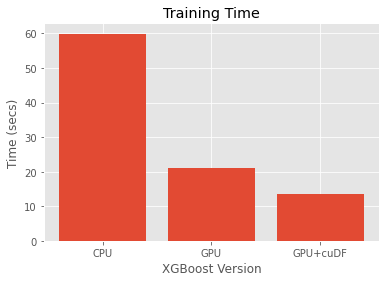

CPU Time Taken:
 59.9 seconds

GPU (no cuDF) Time Taken:
 21.0 seconds

GPU (cuDF) Time Taken:
 13.4 seconds

Total speed-up with RAPIDS:
 446.4 %


In [29]:
labels = 'CPU', 'GPU', 'GPU+cuDF'
sizes = [timetaken_cpu, timetaken_gpu_nocudf, timetaken_gpu]

plt.style.use('ggplot')

x_pos = [i for i, _ in enumerate(labels)]
plt.bar(x_pos, sizes)
plt.xlabel("XGBoost Version")
plt.ylabel("Time (secs)")
plt.title("Training Time")
plt.xticks(x_pos, labels)

plt.show()

print("CPU Time Taken:\n", round(timetaken_cpu,1),"seconds")
print("\nGPU (no cuDF) Time Taken:\n", round(timetaken_gpu_nocudf,1),"seconds")
print("\nGPU (cuDF) Time Taken:\n", round(timetaken_gpu,1),"seconds")
print("\nTotal speed-up with RAPIDS:\n", round(timetaken_cpu/timetaken_gpu*100,1), "%")

As you can see, using the GPU + cuDF we see a significant speed-up. In the next section, we are going to explore the accuracy of the XGBoost model.

<a name="12"></a>
### XGBoost Model Accuracy

Let's look at the model's accuracy on the evalutation set that we will use to compare against our Deep Learning models

In [30]:
print('Starting XGBoost prediction on test dataset...')

# Use trained model to predict on test data set
preds = bst.predict(xgeval)

# Convert predictions to "normal" (0) or "failed"
y_pred = []

THRESHOLD = 0.5
for pred in preds:
    if pred<=THRESHOLD:
        y_pred.append(0)
    if pred>THRESHOLD:
        y_pred.append(1)

# Output array of classifications        
y_pred = np.asarray(y_pred)
        
y_true = df_test_target.values.reshape(len(preds))

print('XGBoost prediction completed')

Starting XGBoost prediction on test dataset...
XGBoost prediction completed


In [31]:
print("Accuracy (Eval)", round(accuracy_score(y_true, y_pred),5))

Accuracy (Eval) 0.99993


<a name="13"></a>
## Measuring Model Accuracy

In this section, we are going to plot the confusion matrix. While accuracy rate provides us with an overall outlook on how well our model is performing, we need more insights into the accuracy. Especially, since our dataset is small, and we need to compromise some aspects of accuracy rate in favor of others. The `classification_report` provides us with the accuracy stats broken down into `precision`, `recall`, `f1-score` and `support`. Before introducing these measures, let's define some abbreviations:

For brevity we are using the following abbreviations: 


- __True Positive (TP)__:  test correctly classifies the input to the class (hard drive failed, and we classified it as fail)
- __False Positive (FP)__:  test incorrectly classifies the input to the class (hard drive is normal, but we classified it as fail)
- __False Negative (FN)__:  test incorrectly misses to classify the input to the class (hard drive failed but we classified as normal)
- __True Negative (TN)__:  test correctly misses to classify the input to the class (hard drive is normal, and we classified as normal)

The first measure is focused on identifying positive cases and is called __recall__. We define recall as the ability of the model to identify all true positive samples of the dataset. In mathematical terms, recall is the ratio of true positives over true positives plus false negatives. By other means, recall tells us, among all the test samples belonging to the output class, how many of them are identified correctly by the model:

\begin{equation*}
recall = \frac{TP}{TP+FN}
\end{equation*}

The next measure, is called __precision__ and is the ability of the model to identify the relevant samples only, and is defined as the ratio of true positives over true positives plus false positives:

\begin{equation*}
precision = \frac{TP}{TP+FP}
\end{equation*}


Selecting a proper threshold, usually stems from a good balance between the precision and recall values. A well-known measure that provides such a balance is `F1 score`, which is a harmonic mean of precision and recall, and defined as:

\begin{equation*}
{F_1 \: score} = 2*\frac{precision*recall}{precision+recall}
\end{equation*}

F1 Score is generally considered a better overall measurement than accuracy when an uneven class distribution exists (large number of True Negatives) as in the case of predicting a hard drive failure.

One very important measure is the recall rate on defective samples. We are interested in models that retrieve as many defective hard drives as possible. We try to predict at least half of the defective hard drives. Let's measure how our model is performing:

In [32]:
print(classification_report(y_true, y_pred, target_names=["normal", "fail"]))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00   3196318
        fail       0.78      0.03      0.06       234

    accuracy                           1.00   3196552
   macro avg       0.89      0.51      0.53   3196552
weighted avg       1.00      1.00      1.00   3196552



<a name="14"></a>
## Interpreting the results

When trying to predict hard drive failure, we can interpret the classification report above in this way:

- Precision is the percentage of times the model is correct when predicting the given class.
- Recall is the percentage of times we predicted that class against the total number of instances of the class in the data set.

Therefore, the classification report above is telling us that the model predicted a failure for ~67% of the 234 fail sequences, and was correct 3% of the time. As for normal hard drives the recall rate is 1.00 and we are accurate ~100% of the time. 

<b>note</b>:  your precision / recall percentages may vary slightly depending on the weights learned during training

## <b>Group Discussion</b>

What do the results above tell us and any ideas how to improve?

In [33]:
print('Summary of training data:')
train_all_count = df.shape[0]
train_fail_count = df[df['failure'] >= 1].shape[0]
print ('- Number of disks : ', train_all_count)
print ('- Number of failed disks: ', train_fail_count)
print ('- Percentage of failed disks: %.4f' %(train_fail_count/train_all_count*100),'%' )

Summary of training data:
- Number of disks :  12237697
- Number of failed disks:  1061
- Percentage of failed disks: 0.0087 %


In [34]:
print('Summary of test data:')
test_all_count = df_t.shape[0]
test_fail_count = df_t[df_t['failure'] >= 1].shape[0]
print ('- Number of disks : ', test_all_count)
print ('- Number of failed disks: ', test_fail_count)
print ('- Percentage of failed disks: %.4f' %(test_fail_count/test_all_count*100),'%' )

Summary of test data:
- Number of disks :  3196552
- Number of failed disks:  234
- Percentage of failed disks: 0.0073 %


Our training and test sets have large class imbalances between normal and failed disks.  During the training process, our model is trying to find the optimal function for the lowest error loss.  Naively, if the model classifies every hard drive as normal, then the model is right more than 99% of the time.

Thus, we need to come up with a strategy to address this imbalance. Some strategies to resolve class imbalance data include:

- Up / Down Sample Classes
- Weighted Class Cost Optimization
- Evaluate various error metrics


In the next section, we are going to resample the "normal" class to match the number of samples within both "normal" and "failure" classes of the dataset.

<a name="15"></a>
## Dealing with Imbalanced Data

When the data samples do not equally represent their classes, it is referred to as "imbalanced data" problem. In our example, we have __3196318__ samples of the normal hard drives, while this number for the "failure" class is only __234__. This clearly results in a model that is biased towards the "normal" samples, and the gradients of the "failure" class tend to vanish during the training epochs.


```
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00   3196318
        fail       0.67      0.03      0.05       234
```


To mitigate the issue, in the next section we are going to resample the "normal" class to be roughly equal to the number of samples in the "failure" class (by a factor of 1.2).

In [35]:
# Sampling training and test data sets for smaller, more balanced test
num_normal_delta = round(train_fail_count * 0.2)
num_normal_test_delta = round(test_fail_count * 0.2)

# Sample training data
df_tmp = df[df['failure'] > 0]
sample_train_count_failed = df_tmp.shape[0]
df_tmp = df_tmp.append(df[df['failure'] == 0].sample(n=(df_tmp.shape[0]+num_normal_delta)))
sample_train_count_normal = df_tmp.shape[0]-sample_train_count_failed

# separate training set features from labels
df_train = df_tmp.drop(columns=['failure'])
df_train_target = pd.DataFrame(df_tmp['failure'])

# Sample test data
df_tmp = df_t[df_t['failure'] > 0]
sample_test_count_failed = df_tmp.shape[0]
df_tmp = df_tmp.append(df_t[df_t['failure'] == 0].sample(n=(df_tmp.shape[0]+num_normal_test_delta)))
sample_test_count_normal = df_tmp.shape[0]-sample_test_count_failed

# separate test set features from labels
df_test = df_tmp.drop(columns=['failure'])
df_test_target = pd.DataFrame(df_tmp['failure'])

# Output name data set sizes
print('Sampled Dataset Sizes:')
print('- Train: Number of Normal Disks :',sample_train_count_normal)
print('- Train: Number of Failed Disks :',sample_train_count_failed)
print('- Test:  Number of Normal Disks :',sample_test_count_normal)
print('- Test:  Number of Failed Disks :',sample_test_count_failed)

Sampled Dataset Sizes:
- Train: Number of Normal Disks : 1273
- Train: Number of Failed Disks : 1061
- Test:  Number of Normal Disks : 281
- Test:  Number of Failed Disks : 234


<a name="e2"></a>
### Exercise 2: Implications of balancing data samples

Before proceeding with training, take some time and think about the implications of rebalancing the data. we have down-sampled the "normal" data points from 3M to ~320, a 10-thousand-time reduction in the number of samples. 
* How do you expect this down-sampling to affect each class? 
* What would be the effect on the precision/recall and f1-score values for each class? 

Write your answers below before training the model:

Next, we are going to build the cuDF data from the pandas DataFrame

In [36]:
# load sampled data into cuDF Dataframe

gdf_train = cudf.DataFrame.from_pandas(df_train)
gdf_train_target = cudf.DataFrame.from_pandas(df_train_target)

gdf_eval = cudf.DataFrame.from_pandas(df_test)
gdf_eval_target = cudf.DataFrame.from_pandas(df_test_target)

And finally perform training on the resampled training data

In [37]:
# GPU, with cuDF

start_time = time.time()

print('Converting cuDF data sets into XGBoost DMatrix format...')
xgtrain = xgb.DMatrix(gdf_train, gdf_train_target)
xgeval = xgb.DMatrix(gdf_eval, gdf_eval_target)
print('Completed converting data sets')

params = {'tree_method': "gpu_"+TREE_METHOD, 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION,
          'gamma': GAMMA, 'subsample': SUBSAMPLE, 'scale_pos_weight': POS_WEIGHT, 'learning_rate': 0.05, 'silent': 1}

print('Starting GPU XGBoost Training with cuDF Dataframes...')
bst = xgb.train(params, xgtrain, 20, evals=[(xgtrain, "train"), (xgeval, "eval")],
                early_stopping_rounds=EARLY_STOP)

timetaken_gpu = time.time() - start_time
print('GPU XGBoost Training with cuDF Dataframes compeleted - elapsed time:', timetaken_gpu,'seconds')

Converting cuDF data sets into XGBoost DMatrix format...
Completed converting data sets
Starting GPU XGBoost Training with cuDF Dataframes...
[05:42:52] WARNING: /conda/conda-bld/xgboost_1591204597597/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:0.48699	eval-rmse:0.48674
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:0.47459	eval-rmse:0.47412
[2]	train-rmse:0.46313	eval-rmse:0.46302
[3]	train-rmse:0.45193	eval-rmse:0.45255
[4]	train-rmse:0.44135	eval-rmse:0.44241
[5]	train-rmse:0.43197	eval-rmse:0.43321
[6]	train-rmse:0.42303	eval-rmse:0.42477
[7]	train-rmse:0.41477	eval-rmse:0.41808
[8]	train-rmse:0.407

Now that the model is trained, let's run it over the test set.

In [38]:
print('Starting XGBoost prediction on test dataset...')

# Use trained model to predict on test data set
preds = bst.predict(xgeval)

# Convert predictions to "normal" (0) or "failed"
y_pred = []
THRESHOLD = 0.5

for pred in preds:
    if pred<=THRESHOLD:
        y_pred.append(0)
    if pred>THRESHOLD:
        y_pred.append(1)

# Output array of classifications                
y_pred = np.asarray(y_pred)
        
y_true = df_test_target.values.reshape(len(preds))
print('XGBoost prediction completed')

Starting XGBoost prediction on test dataset...
XGBoost prediction completed


And finally review accuracy with the new results.

In [39]:
print("Accuracy (Eval)", round(accuracy_score(y_true, y_pred),5))

print(classification_report(y_true, y_pred, target_names=["normal", "fail"]))

Accuracy (Eval) 0.85243
              precision    recall  f1-score   support

      normal       0.81      0.96      0.88       281
        fail       0.93      0.73      0.82       234

    accuracy                           0.85       515
   macro avg       0.87      0.84      0.85       515
weighted avg       0.87      0.85      0.85       515



As you can see, the recall/precision values for the "fail" class are hugely improved. The cost we pay here is the reduction in the precision/recall values of the "normal" class. Could you explain some scenarios where each of these strategies would be applicable? 
Finally, Compare the obtained results with your answers to exercise 2. How closely were you able to predict the results?


## Summary

In this lab, we learned how to work with a sample dataset and curate, normalize, and filter data to prepare it for our XGBoost model. We reviewed the XGBoost model and learned how to utilize the cuDF data structure to accelerate the training/testing phases for the XGBoost model. Moreover, we learned how to modify the data to mitigate the issue of imbalanced classes.
In the next two labs, we will use deep-learning-based approaches for classification and prediction.

<a name="All-answers"></a>
## Answers to selected exercises:
---

<a name="a1"></a>
**Exercise 1: More insights into data:**



In [ ]:
df = df.loc[:, (df != 0).any(axis=0)]

Click [here](#e1) to go back